# 内容
- データ読み込み
- split
- x, y生成
- 学習
- 評価
- submit

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

import utils as ut

## 準備

In [2]:
DEBUG = True
ut.seed_everything(24)

In [3]:
tr_file = "../../input/ventilator-pressure-prediction/train.csv"
ts_file = "../../input/ventilator-pressure-prediction/test.csv"
tr_df = pd.read_csv(tr_file)
ts_df = pd.read_csv(ts_file)

In [4]:
# shuffled breath_id
tr_df["shuffled_breath_id"] = ut.make_shuffled_id(tr_df["breath_id"])

## 学習

In [5]:
def make_x(df):
    ft = ut.Feature()
    x = ft.transform(df)
    return x

def make_y(df):
    tg = ut.Target()
    y = tg.transform(df)
    return y

def get_model(n_feat, prefix=""):
    model_prms = {
        "scaling_prms": dict(n_scaler=n_feat),
        "dnn_prms": dict(n_feat=n_feat, n_channel=256, dropout=0.0, n_rc_layer=4), 
        "tr_prms": dict(
            criterion=ut.VentilatorLoss(),
            opt="adamw",
            opt_params=dict(lr=0.001, weight_decay=1e-6),
            sch_params=None, #{'max_lr': lr, 'pct_start':0.1, 'div_factor':5, 'final_div_factor': 10000}, # initial_lr = max_lr/div_factor, min_lr = initial_lr/final_div_factor
            epochs=20, 
            prefix=prefix,
            save_best=True,
            maximize_score=False,
        ), 
        "seq_len": 80,
        "use_seq_len": 40, 
        "train_batch_size": 256,
        "pred_batch_size": 1024,
    }
    model = ut.Model(**model_prms)
    return model

def run_fold(tr_df, vl_df, prefix=""):
    # x, y
    tr_x = make_x(tr_df)
    tr_y = make_y(tr_df)
    vl_x = make_x(vl_df)
    vl_y = make_y(vl_df)

    model = get_model(tr_x.shape[1], prefix)
    model.fit(tr_x, tr_y, vl_x, vl_y)

    #tr_pred = model.predict(tr_x)
    vl_pred = model.predict(vl_x)

    #tr_df = pd.concat([tr_df, tr_x, pd.DataFrame(tr_pred, index=tr_df.index, columns=["pred"])], axis=1)
    vl_df = pd.concat([vl_df, vl_x, pd.DataFrame(vl_pred, index=vl_df.index, columns=["pred"])], axis=1)
    return model, tr_df, vl_df

def run_cv(df, n_split, n_fold):
    kf = model_selection.GroupKFold(n_splits=n_split)

    oof_df = []
    for fold, (tr_idxs, vl_idxs) in enumerate(kf.split(X=np.arange(len(df)), groups=df["shuffled_breath_id"].values)):
        if n_fold <= fold:
            break
        print("fold", fold)
        prefix = f"fold{fold}_"

        tr_df = df.iloc[tr_idxs].copy()
        vl_df = df.iloc[vl_idxs].copy()
        tr_df["fold"] = fold
        vl_df["fold"] = fold

        model, tr_df, vl_df = run_fold(tr_df, vl_df, prefix)

        oof_df.append(vl_df)
        with open(f'{prefix}model.pickle', mode='wb') as fp:
            model.set_dev('cpu')
            pickle.dump(model, fp)

        #tr_df.to_csv(f"{prefix}tr_df.csv", index=False)
        #vl_df.to_csv(f"{prefix}vl_df.csv", index=False)
    oof_df = pd.concat(oof_df, axis=0)

    return oof_df

In [6]:
n_split = 5
n_fold = 5
oof_df = run_cv(tr_df, n_split, n_fold)
oof_df.to_csv("oof.csv")

fold 0


  0%|          | 0/235 [00:00<?, ?it/s]


epoch  0
lr  0.001


  1%|          | 2/235 [00:00<00:16, 13.71it/s]


Train Loss: 0.1571 | Score: 0.15708
{'loss': 0.15708185995512822, 'score': 0.15708186, 'mae': 0.15708186}
Valid Loss: 0.1019 | Score: 0.10195
{'loss': 0.10193762034177781, 'score': 0.10195271, 'mae': 0.10195271}
Update best score : 0.10195271
Save model : fold0_model.pth

epoch  1
lr  0.001


  1%|          | 2/235 [00:00<00:16, 13.72it/s]


Train Loss: 0.0906 | Score: 0.09063
{'loss': 0.09062740022831775, 'score': 0.09062739, 'mae': 0.09062739}
Valid Loss: 0.0774 | Score: 0.07740
{'loss': 0.07740282565355301, 'score': 0.07739752, 'mae': 0.07739752}
Update best score : 0.07739752
Save model : fold0_model.pth

epoch  2
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0741 | Score: 0.07413
{'loss': 0.07412548290288194, 'score': 0.07412547, 'mae': 0.07412547}
Valid Loss: 0.0695 | Score: 0.06950
{'loss': 0.06950267901023229, 'score': 0.06949695, 'mae': 0.06949695}
Update best score : 0.06949695
Save model : fold0_model.pth

epoch  3
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0618 | Score: 0.06179
{'loss': 0.06179258504763563, 'score': 0.06179257, 'mae': 0.06179257}
Valid Loss: 0.0607 | Score: 0.06068
{'loss': 0.06071836426854134, 'score': 0.06067903, 'mae': 0.06067903}
Update best score : 0.06067903
Save model : fold0_model.pth

epoch  4
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0557 | Score: 0.05574
{'loss': 0.055737628454857684, 'score': 0.055737622, 'mae': 0.055737622}
Valid Loss: 0.0515 | Score: 0.05145
{'loss': 0.05148442188898723, 'score': 0.05145167, 'mae': 0.05145167}
Update best score : 0.05145167
Save model : fold0_model.pth

epoch  5
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0511 | Score: 0.05108
{'loss': 0.05108105078973669, 'score': 0.051081046, 'mae': 0.051081046}
Valid Loss: 0.0483 | Score: 0.04832
{'loss': 0.04834950988491376, 'score': 0.04832219, 'mae': 0.04832219}
Update best score : 0.04832219
Save model : fold0_model.pth

epoch  6
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.05it/s]


Train Loss: 0.0477 | Score: 0.04770
{'loss': 0.047699827352102764, 'score': 0.047699858, 'mae': 0.047699858}
Valid Loss: 0.0494 | Score: 0.04939
{'loss': 0.0494299478828907, 'score': 0.04938949, 'mae': 0.04938949}

epoch  7
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.02it/s]


Train Loss: 0.0463 | Score: 0.04629
{'loss': 0.04628846090524755, 'score': 0.046288498, 'mae': 0.046288498}
Valid Loss: 0.0425 | Score: 0.04251
{'loss': 0.04253145307302475, 'score': 0.042512804, 'mae': 0.042512804}
Update best score : 0.042512804
Save model : fold0_model.pth

epoch  8
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.88it/s]


Train Loss: 0.0430 | Score: 0.04295
{'loss': 0.04295134802765035, 'score': 0.042951353, 'mae': 0.042951353}
Valid Loss: 0.0427 | Score: 0.04270
{'loss': 0.04270433535178502, 'score': 0.042695854, 'mae': 0.042695854}

epoch  9
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0417 | Score: 0.04169
{'loss': 0.04168781091241126, 'score': 0.04168778, 'mae': 0.04168778}
Valid Loss: 0.0419 | Score: 0.04188
{'loss': 0.04191628322005272, 'score': 0.041882712, 'mae': 0.041882712}
Update best score : 0.041882712
Save model : fold0_model.pth

epoch  10
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0399 | Score: 0.03994
{'loss': 0.0399435078844111, 'score': 0.0399435, 'mae': 0.0399435}
Valid Loss: 0.0393 | Score: 0.03930
{'loss': 0.039284483343362805, 'score': 0.039300747, 'mae': 0.039300747}
Update best score : 0.039300747
Save model : fold0_model.pth

epoch  11
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.85it/s]


Train Loss: 0.0380 | Score: 0.03803
{'loss': 0.03802984856227611, 'score': 0.038029827, 'mae': 0.038029827}
Valid Loss: 0.0376 | Score: 0.03762
{'loss': 0.03764597376187642, 'score': 0.03762333, 'mae': 0.03762333}
Update best score : 0.03762333
Save model : fold0_model.pth

epoch  12
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0381 | Score: 0.03809
{'loss': 0.03809251851857977, 'score': 0.03809252, 'mae': 0.03809252}
Valid Loss: 0.0367 | Score: 0.03668
{'loss': 0.03670356844862302, 'score': 0.036680825, 'mae': 0.036680825}
Update best score : 0.036680825
Save model : fold0_model.pth

epoch  13
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.28it/s]


Train Loss: 0.0369 | Score: 0.03686
{'loss': 0.036857881254338205, 'score': 0.036857896, 'mae': 0.036857896}
Valid Loss: 0.0376 | Score: 0.03759
{'loss': 0.037602671732505165, 'score': 0.037594352, 'mae': 0.037594352}

epoch  14
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0348 | Score: 0.03485
{'loss': 0.034849646600319986, 'score': 0.03484964, 'mae': 0.03484964}
Valid Loss: 0.0345 | Score: 0.03449
{'loss': 0.034505168348550795, 'score': 0.034494337, 'mae': 0.034494337}
Update best score : 0.034494337
Save model : fold0_model.pth

epoch  15
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.64it/s]


Train Loss: 0.0341 | Score: 0.03412
{'loss': 0.03411964660787836, 'score': 0.034119666, 'mae': 0.034119666}
Valid Loss: 0.0343 | Score: 0.03431
{'loss': 0.034331222126881285, 'score': 0.034310352, 'mae': 0.034310352}
Update best score : 0.034310352
Save model : fold0_model.pth

epoch  16
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.64it/s]


Train Loss: 0.0335 | Score: 0.03346
{'loss': 0.03346123937913712, 'score': 0.03346124, 'mae': 0.03346124}
Valid Loss: 0.0327 | Score: 0.03267
{'loss': 0.032692886392275494, 'score': 0.032673296, 'mae': 0.032673296}
Update best score : 0.032673296
Save model : fold0_model.pth

epoch  17
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.11it/s]


Train Loss: 0.0327 | Score: 0.03270
{'loss': 0.032697922554104884, 'score': 0.03269792, 'mae': 0.03269792}
Valid Loss: 0.0382 | Score: 0.03822
{'loss': 0.038233613967895506, 'score': 0.038217664, 'mae': 0.038217664}

epoch  18
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0324 | Score: 0.03243
{'loss': 0.03243416544604809, 'score': 0.03243417, 'mae': 0.03243417}
Valid Loss: 0.0322 | Score: 0.03217
{'loss': 0.03218482670684655, 'score': 0.03217347, 'mae': 0.03217347}
Update best score : 0.03217347
Save model : fold0_model.pth

epoch  19
lr  0.001


100%|██████████| 15/15 [00:01<00:00, 11.81it/s]



Train Loss: 0.0304 | Score: 0.03042
{'loss': 0.030419549345970152, 'score': 0.030419558, 'mae': 0.030419558}
Valid Loss: 0.0335 | Score: 0.03348
{'loss': 0.03350205048918724, 'score': 0.03348311, 'mae': 0.03348311}


100%|██████████| 15/15 [00:01<00:00, 13.25it/s]


fold 1


  1%|          | 2/235 [00:00<00:17, 13.19it/s]


epoch  0
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.37it/s]


Train Loss: 0.1539 | Score: 0.15386
{'loss': 0.15386322343603093, 'score': 0.1538632, 'mae': 0.1538632}
Valid Loss: 0.0988 | Score: 0.09880
{'loss': 0.0987690418958664, 'score': 0.098800376, 'mae': 0.098800376}
Update best score : 0.098800376
Save model : fold1_model.pth

epoch  1
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.11it/s]


Train Loss: 0.0886 | Score: 0.08859
{'loss': 0.08858850189345949, 'score': 0.08858855, 'mae': 0.08858855}
Valid Loss: 0.0821 | Score: 0.08219
{'loss': 0.08214035232861837, 'score': 0.08218772, 'mae': 0.08218772}
Update best score : 0.08218772
Save model : fold1_model.pth

epoch  2
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.46it/s]


Train Loss: 0.0732 | Score: 0.07319
{'loss': 0.07319400169430895, 'score': 0.07319398, 'mae': 0.07319398}
Valid Loss: 0.0650 | Score: 0.06494
{'loss': 0.06495438317457834, 'score': 0.06494384, 'mae': 0.06494384}
Update best score : 0.06494384
Save model : fold1_model.pth

epoch  3
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.37it/s]


Train Loss: 0.0617 | Score: 0.06166
{'loss': 0.06166308357360515, 'score': 0.061663065, 'mae': 0.061663065}
Valid Loss: 0.0564 | Score: 0.05646
{'loss': 0.056436293820540114, 'score': 0.05646119, 'mae': 0.05646119}
Update best score : 0.05646119
Save model : fold1_model.pth

epoch  4
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0564 | Score: 0.05642
{'loss': 0.056419024568922976, 'score': 0.056419034, 'mae': 0.056419034}
Valid Loss: 0.0520 | Score: 0.05202
{'loss': 0.05200331484278043, 'score': 0.052024648, 'mae': 0.052024648}
Update best score : 0.052024648
Save model : fold1_model.pth

epoch  5
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0517 | Score: 0.05169
{'loss': 0.05168831204163267, 'score': 0.0516883, 'mae': 0.0516883}
Valid Loss: 0.0474 | Score: 0.04746
{'loss': 0.047436286509037015, 'score': 0.047458306, 'mae': 0.047458306}
Update best score : 0.047458306
Save model : fold1_model.pth

epoch  6
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.77it/s]


Train Loss: 0.0475 | Score: 0.04750
{'loss': 0.04749984755478007, 'score': 0.047499817, 'mae': 0.047499817}
Valid Loss: 0.0483 | Score: 0.04834
{'loss': 0.04830111091335614, 'score': 0.04833712, 'mae': 0.04833712}

epoch  7
lr  0.001


  1%|          | 2/235 [00:00<00:16, 13.74it/s]


Train Loss: 0.0454 | Score: 0.04537
{'loss': 0.04537411465289745, 'score': 0.04537413, 'mae': 0.04537413}
Valid Loss: 0.0434 | Score: 0.04340
{'loss': 0.04337831114729245, 'score': 0.04340139, 'mae': 0.04340139}
Update best score : 0.04340139
Save model : fold1_model.pth

epoch  8
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.19it/s]


Train Loss: 0.0437 | Score: 0.04369
{'loss': 0.043694111641417156, 'score': 0.04369409, 'mae': 0.04369409}
Valid Loss: 0.0461 | Score: 0.04616
{'loss': 0.04612740178902944, 'score': 0.046157587, 'mae': 0.046157587}

epoch  9
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0414 | Score: 0.04143
{'loss': 0.041429154939473946, 'score': 0.041429143, 'mae': 0.041429143}
Valid Loss: 0.0417 | Score: 0.04174
{'loss': 0.04171578933795293, 'score': 0.04174239, 'mae': 0.04174239}
Update best score : 0.04174239
Save model : fold1_model.pth

epoch  10
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.46it/s]


Train Loss: 0.0400 | Score: 0.04002
{'loss': 0.04002104894594943, 'score': 0.040021047, 'mae': 0.040021047}
Valid Loss: 0.0412 | Score: 0.04124
{'loss': 0.04119138941168785, 'score': 0.041236382, 'mae': 0.041236382}
Update best score : 0.041236382
Save model : fold1_model.pth

epoch  11
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.02it/s]


Train Loss: 0.0389 | Score: 0.03888
{'loss': 0.03888226427296375, 'score': 0.03888228, 'mae': 0.03888228}
Valid Loss: 0.0373 | Score: 0.03730
{'loss': 0.037291639298200605, 'score': 0.03730296, 'mae': 0.03730296}
Update best score : 0.03730296
Save model : fold1_model.pth

epoch  12
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.55it/s]


Train Loss: 0.0371 | Score: 0.03711
{'loss': 0.037111157004503494, 'score': 0.037111126, 'mae': 0.037111126}
Valid Loss: 0.0377 | Score: 0.03776
{'loss': 0.03773701985677083, 'score': 0.037763376, 'mae': 0.037763376}

epoch  13
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.37it/s]


Train Loss: 0.0364 | Score: 0.03640
{'loss': 0.036404579521176664, 'score': 0.036404576, 'mae': 0.036404576}
Valid Loss: 0.0353 | Score: 0.03533
{'loss': 0.03530967012047768, 'score': 0.035329804, 'mae': 0.035329804}
Update best score : 0.035329804
Save model : fold1_model.pth

epoch  14
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.02it/s]


Train Loss: 0.0348 | Score: 0.03480
{'loss': 0.034803097251247854, 'score': 0.03480311, 'mae': 0.03480311}
Valid Loss: 0.0372 | Score: 0.03724
{'loss': 0.037212008237838747, 'score': 0.0372359, 'mae': 0.0372359}

epoch  15
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.11it/s]


Train Loss: 0.0342 | Score: 0.03421
{'loss': 0.034208867294674226, 'score': 0.034208875, 'mae': 0.034208875}
Valid Loss: 0.0357 | Score: 0.03570
{'loss': 0.03568050041794777, 'score': 0.035697054, 'mae': 0.035697054}

epoch  16
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0338 | Score: 0.03377
{'loss': 0.03377002782802632, 'score': 0.033770036, 'mae': 0.033770036}
Valid Loss: 0.0347 | Score: 0.03475
{'loss': 0.03472519740462303, 'score': 0.034747258, 'mae': 0.034747258}
Update best score : 0.034747258
Save model : fold1_model.pth

epoch  17
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0328 | Score: 0.03285
{'loss': 0.03284796084019732, 'score': 0.032847963, 'mae': 0.032847963}
Valid Loss: 0.0324 | Score: 0.03241
{'loss': 0.032382883379856744, 'score': 0.03240549, 'mae': 0.03240549}
Update best score : 0.03240549
Save model : fold1_model.pth

epoch  18
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.28it/s]


Train Loss: 0.0320 | Score: 0.03196
{'loss': 0.03196077579830555, 'score': 0.031960793, 'mae': 0.031960793}
Valid Loss: 0.0341 | Score: 0.03412
{'loss': 0.034088295449813205, 'score': 0.034116518, 'mae': 0.034116518}

epoch  19
lr  0.001


100%|██████████| 15/15 [00:01<00:00, 11.81it/s]



Train Loss: 0.0311 | Score: 0.03108
{'loss': 0.03107654241488335, 'score': 0.031076547, 'mae': 0.031076547}
Valid Loss: 0.0323 | Score: 0.03234
{'loss': 0.032320931429664294, 'score': 0.032338306, 'mae': 0.032338306}
Update best score : 0.032338306
Save model : fold1_model.pth


100%|██████████| 15/15 [00:01<00:00, 13.27it/s]


fold 2


  1%|          | 2/235 [00:00<00:17, 13.19it/s]


epoch  0
lr  0.001


  1%|          | 2/235 [00:00<00:16, 13.93it/s]


Train Loss: 0.1648 | Score: 0.16478
{'loss': 0.16477864701697167, 'score': 0.16477862, 'mae': 0.16477862}
Valid Loss: 0.1041 | Score: 0.10415
{'loss': 0.10410436540842057, 'score': 0.10415371, 'mae': 0.10415371}
Update best score : 0.10415371
Save model : fold2_model.pth

epoch  1
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.37it/s]


Train Loss: 0.0952 | Score: 0.09515
{'loss': 0.09515231071000403, 'score': 0.09515227, 'mae': 0.09515227}
Valid Loss: 0.0876 | Score: 0.08763
{'loss': 0.08761269797881445, 'score': 0.08762858, 'mae': 0.08762858}
Update best score : 0.08762858
Save model : fold2_model.pth

epoch  2
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0773 | Score: 0.07730
{'loss': 0.0772969477988304, 'score': 0.07729695, 'mae': 0.07729695}
Valid Loss: 0.0698 | Score: 0.06978
{'loss': 0.06978775411844254, 'score': 0.06978479, 'mae': 0.06978479}
Update best score : 0.06978479
Save model : fold2_model.pth

epoch  3
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.64it/s]


Train Loss: 0.0657 | Score: 0.06574
{'loss': 0.06573915137572492, 'score': 0.06573913, 'mae': 0.06573913}
Valid Loss: 0.0607 | Score: 0.06070
{'loss': 0.060715121279160185, 'score': 0.06069853, 'mae': 0.06069853}
Update best score : 0.06069853
Save model : fold2_model.pth

epoch  4
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.64it/s]


Train Loss: 0.0578 | Score: 0.05784
{'loss': 0.05783660407079027, 'score': 0.057836596, 'mae': 0.057836596}
Valid Loss: 0.0574 | Score: 0.05741
{'loss': 0.05742850328485171, 'score': 0.057413172, 'mae': 0.057413172}
Update best score : 0.057413172
Save model : fold2_model.pth

epoch  5
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0528 | Score: 0.05283
{'loss': 0.05283293067774874, 'score': 0.052832954, 'mae': 0.052832954}
Valid Loss: 0.0506 | Score: 0.05054
{'loss': 0.050561744968096414, 'score': 0.05054085, 'mae': 0.05054085}
Update best score : 0.05054085
Save model : fold2_model.pth

epoch  6
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0483 | Score: 0.04833
{'loss': 0.04833493779631371, 'score': 0.04833494, 'mae': 0.04833494}
Valid Loss: 0.0448 | Score: 0.04477
{'loss': 0.04477369263768196, 'score': 0.044769976, 'mae': 0.044769976}
Update best score : 0.044769976
Save model : fold2_model.pth

epoch  7
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.85it/s]


Train Loss: 0.0447 | Score: 0.04468
{'loss': 0.04468473884019446, 'score': 0.04468475, 'mae': 0.04468475}
Valid Loss: 0.0474 | Score: 0.04739
{'loss': 0.04737130552530289, 'score': 0.04739129, 'mae': 0.04739129}

epoch  8
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0426 | Score: 0.04256
{'loss': 0.04255952713020304, 'score': 0.042559527, 'mae': 0.042559527}
Valid Loss: 0.0413 | Score: 0.04128
{'loss': 0.041267580290635424, 'score': 0.04128269, 'mae': 0.04128269}
Update best score : 0.04128269
Save model : fold2_model.pth

epoch  9
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.37it/s]


Train Loss: 0.0413 | Score: 0.04133
{'loss': 0.04132712911418144, 'score': 0.041327123, 'mae': 0.041327123}
Valid Loss: 0.0455 | Score: 0.04549
{'loss': 0.045468179136514665, 'score': 0.0454905, 'mae': 0.0454905}

epoch  10
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.85it/s]


Train Loss: 0.0400 | Score: 0.03996
{'loss': 0.039958589904485864, 'score': 0.039958585, 'mae': 0.039958585}
Valid Loss: 0.0445 | Score: 0.04452
{'loss': 0.044508148233095804, 'score': 0.044521507, 'mae': 0.044521507}

epoch  11
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.55it/s]


Train Loss: 0.0387 | Score: 0.03867
{'loss': 0.03867309599163685, 'score': 0.03867311, 'mae': 0.03867311}
Valid Loss: 0.0393 | Score: 0.03929
{'loss': 0.03927016879121462, 'score': 0.039290957, 'mae': 0.039290957}
Update best score : 0.039290957
Save model : fold2_model.pth

epoch  12
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0370 | Score: 0.03696
{'loss': 0.036961249666328126, 'score': 0.03696126, 'mae': 0.03696126}
Valid Loss: 0.0365 | Score: 0.03646
{'loss': 0.03645174627502759, 'score': 0.036459263, 'mae': 0.036459263}
Update best score : 0.036459263
Save model : fold2_model.pth

epoch  13
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.85it/s]


Train Loss: 0.0367 | Score: 0.03667
{'loss': 0.03666729357965449, 'score': 0.036667302, 'mae': 0.036667302}
Valid Loss: 0.0392 | Score: 0.03922
{'loss': 0.03922039171059926, 'score': 0.039224908, 'mae': 0.039224908}

epoch  14
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0343 | Score: 0.03427
{'loss': 0.03426941157655513, 'score': 0.034269404, 'mae': 0.034269404}
Valid Loss: 0.0364 | Score: 0.03638
{'loss': 0.03637909814715386, 'score': 0.0363831, 'mae': 0.0363831}
Update best score : 0.0363831
Save model : fold2_model.pth

epoch  15
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0339 | Score: 0.03389
{'loss': 0.033891862781440955, 'score': 0.03389188, 'mae': 0.03389188}
Valid Loss: 0.0348 | Score: 0.03476
{'loss': 0.03476400872071584, 'score': 0.034760624, 'mae': 0.034760624}
Update best score : 0.034760624
Save model : fold2_model.pth

epoch  16
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0333 | Score: 0.03333
{'loss': 0.033325993008119, 'score': 0.033325993, 'mae': 0.033325993}
Valid Loss: 0.0327 | Score: 0.03272
{'loss': 0.032710375760992366, 'score': 0.032721013, 'mae': 0.032721013}
Update best score : 0.032721013
Save model : fold2_model.pth

epoch  17
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.17it/s]


Train Loss: 0.0319 | Score: 0.03193
{'loss': 0.03192986551910005, 'score': 0.03192986, 'mae': 0.03192986}
Valid Loss: 0.0335 | Score: 0.03355
{'loss': 0.0335354616244634, 'score': 0.033552058, 'mae': 0.033552058}

epoch  18
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0315 | Score: 0.03152
{'loss': 0.03152198853327873, 'score': 0.03152199, 'mae': 0.03152199}
Valid Loss: 0.0322 | Score: 0.03224
{'loss': 0.032239945605397224, 'score': 0.032240823, 'mae': 0.032240823}
Update best score : 0.032240823
Save model : fold2_model.pth

epoch  19
lr  0.001


100%|██████████| 15/15 [00:01<00:00, 11.15it/s]



Train Loss: 0.0313 | Score: 0.03130
{'loss': 0.03130343249662126, 'score': 0.031303424, 'mae': 0.031303424}
Valid Loss: 0.0319 | Score: 0.03188
{'loss': 0.031898066898187, 'score': 0.031884294, 'mae': 0.031884294}
Update best score : 0.031884294
Save model : fold2_model.pth


100%|██████████| 15/15 [00:01<00:00, 12.90it/s]


fold 3


  1%|          | 2/235 [00:00<00:18, 12.42it/s]


epoch  0
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.1540 | Score: 0.15404
{'loss': 0.15403763391870134, 'score': 0.1540377, 'mae': 0.1540377}
Valid Loss: 0.0984 | Score: 0.09847
{'loss': 0.09842145989338556, 'score': 0.09847046, 'mae': 0.09847046}
Update best score : 0.09847046
Save model : fold3_model.pth

epoch  1
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0914 | Score: 0.09140
{'loss': 0.09139800344375854, 'score': 0.091397986, 'mae': 0.091397986}
Valid Loss: 0.0793 | Score: 0.07929
{'loss': 0.0793139214317004, 'score': 0.07929486, 'mae': 0.07929486}
Update best score : 0.07929486
Save model : fold3_model.pth

epoch  2
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0735 | Score: 0.07351
{'loss': 0.07351466604369752, 'score': 0.073514655, 'mae': 0.073514655}
Valid Loss: 0.0634 | Score: 0.06336
{'loss': 0.06335713615020117, 'score': 0.0633647, 'mae': 0.0633647}
Update best score : 0.0633647
Save model : fold3_model.pth

epoch  3
lr  0.001


  1%|          | 2/235 [00:00<00:16, 14.29it/s]


Train Loss: 0.0619 | Score: 0.06190
{'loss': 0.06190109817271537, 'score': 0.061901107, 'mae': 0.061901107}
Valid Loss: 0.0617 | Score: 0.06171
{'loss': 0.0617072398463885, 'score': 0.061711736, 'mae': 0.061711736}
Update best score : 0.061711736
Save model : fold3_model.pth

epoch  4
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0553 | Score: 0.05525
{'loss': 0.05525323009871422, 'score': 0.055253226, 'mae': 0.055253226}
Valid Loss: 0.0514 | Score: 0.05142
{'loss': 0.05140927309791247, 'score': 0.051415943, 'mae': 0.051415943}
Update best score : 0.051415943
Save model : fold3_model.pth

epoch  5
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0514 | Score: 0.05143
{'loss': 0.05142880633790442, 'score': 0.051428832, 'mae': 0.051428832}
Valid Loss: 0.0502 | Score: 0.05026
{'loss': 0.05023345748583476, 'score': 0.050258346, 'mae': 0.050258346}
Update best score : 0.050258346
Save model : fold3_model.pth

epoch  6
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0473 | Score: 0.04733
{'loss': 0.04732891742853408, 'score': 0.047328904, 'mae': 0.047328904}
Valid Loss: 0.0453 | Score: 0.04533
{'loss': 0.045319428543249766, 'score': 0.045334373, 'mae': 0.045334373}
Update best score : 0.045334373
Save model : fold3_model.pth

epoch  7
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.69it/s]


Train Loss: 0.0453 | Score: 0.04534
{'loss': 0.04533856962906553, 'score': 0.04533857, 'mae': 0.04533857}
Valid Loss: 0.0487 | Score: 0.04868
{'loss': 0.04865903084476789, 'score': 0.048683476, 'mae': 0.048683476}

epoch  8
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0442 | Score: 0.04419
{'loss': 0.04418515074760356, 'score': 0.044185154, 'mae': 0.044185154}
Valid Loss: 0.0412 | Score: 0.04121
{'loss': 0.041197608411312106, 'score': 0.041206185, 'mae': 0.041206185}
Update best score : 0.041206185
Save model : fold3_model.pth

epoch  9
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.83it/s]


Train Loss: 0.0414 | Score: 0.04139
{'loss': 0.0413863960891328, 'score': 0.041386396, 'mae': 0.041386396}
Valid Loss: 0.0392 | Score: 0.03921
{'loss': 0.03919582764307658, 'score': 0.039213642, 'mae': 0.039213642}
Update best score : 0.039213642
Save model : fold3_model.pth

epoch  10
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0399 | Score: 0.03995
{'loss': 0.0399466502064086, 'score': 0.039946638, 'mae': 0.039946638}
Valid Loss: 0.0377 | Score: 0.03769
{'loss': 0.03768576706449191, 'score': 0.037690997, 'mae': 0.037690997}
Update best score : 0.037690997
Save model : fold3_model.pth

epoch  11
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0389 | Score: 0.03887
{'loss': 0.038874072232779035, 'score': 0.038874086, 'mae': 0.038874086}
Valid Loss: 0.0370 | Score: 0.03698
{'loss': 0.03697208637992541, 'score': 0.0369762, 'mae': 0.0369762}
Update best score : 0.0369762
Save model : fold3_model.pth

epoch  12
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.30it/s]


Train Loss: 0.0372 | Score: 0.03723
{'loss': 0.03723484062133951, 'score': 0.037234843, 'mae': 0.037234843}
Valid Loss: 0.0366 | Score: 0.03653
{'loss': 0.03655175343155861, 'score': 0.036532, 'mae': 0.036532}
Update best score : 0.036532
Save model : fold3_model.pth

epoch  13
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.53it/s]


Train Loss: 0.0362 | Score: 0.03618
{'loss': 0.0361769834810749, 'score': 0.036176987, 'mae': 0.036176987}
Valid Loss: 0.0366 | Score: 0.03662
{'loss': 0.03662497078378995, 'score': 0.03661954, 'mae': 0.03661954}

epoch  14
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0356 | Score: 0.03559
{'loss': 0.035589938523604515, 'score': 0.035589945, 'mae': 0.035589945}
Valid Loss: 0.0365 | Score: 0.03651
{'loss': 0.0365243765215079, 'score': 0.03651321, 'mae': 0.03651321}
Update best score : 0.03651321
Save model : fold3_model.pth

epoch  15
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0344 | Score: 0.03439
{'loss': 0.03439448629605009, 'score': 0.034394484, 'mae': 0.034394484}
Valid Loss: 0.0327 | Score: 0.03268
{'loss': 0.032673249517877895, 'score': 0.03268177, 'mae': 0.03268177}
Update best score : 0.03268177
Save model : fold3_model.pth

epoch  16
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.13it/s]


Train Loss: 0.0338 | Score: 0.03377
{'loss': 0.03377413239250792, 'score': 0.033774126, 'mae': 0.033774126}
Valid Loss: 0.0349 | Score: 0.03491
{'loss': 0.03488778819640478, 'score': 0.034905985, 'mae': 0.034905985}

epoch  17
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.11it/s]


Train Loss: 0.0326 | Score: 0.03261
{'loss': 0.03261230540402392, 'score': 0.032612305, 'mae': 0.032612305}
Valid Loss: 0.0344 | Score: 0.03436
{'loss': 0.03437907174229622, 'score': 0.034360256, 'mae': 0.034360256}

epoch  18
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.85it/s]


Train Loss: 0.0317 | Score: 0.03168
{'loss': 0.03167549821132041, 'score': 0.03167549, 'mae': 0.03167549}
Valid Loss: 0.0317 | Score: 0.03172
{'loss': 0.03170682912071546, 'score': 0.031716358, 'mae': 0.031716358}
Update best score : 0.031716358
Save model : fold3_model.pth

epoch  19
lr  0.001


100%|██████████| 15/15 [00:01<00:00, 11.89it/s]



Train Loss: 0.0308 | Score: 0.03083
{'loss': 0.030832557300937938, 'score': 0.030832551, 'mae': 0.030832551}
Valid Loss: 0.0327 | Score: 0.03266
{'loss': 0.03267064653337002, 'score': 0.03266259, 'mae': 0.03266259}


100%|██████████| 15/15 [00:01<00:00, 13.05it/s]


fold 4


  1%|          | 2/235 [00:00<00:17, 13.28it/s]


epoch  0
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.1543 | Score: 0.15432
{'loss': 0.15431804279697703, 'score': 0.15431806, 'mae': 0.15431806}
Valid Loss: 0.1072 | Score: 0.10721
{'loss': 0.10721681366364161, 'score': 0.10720845, 'mae': 0.10720845}
Update best score : 0.10720845
Save model : fold4_model.pth

epoch  1
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0903 | Score: 0.09027
{'loss': 0.09027093994490644, 'score': 0.09027092, 'mae': 0.09027092}
Valid Loss: 0.0787 | Score: 0.07867
{'loss': 0.0786841223637263, 'score': 0.078673385, 'mae': 0.078673385}
Update best score : 0.078673385
Save model : fold4_model.pth

epoch  2
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0732 | Score: 0.07315
{'loss': 0.07315127865431156, 'score': 0.073151276, 'mae': 0.073151276}
Valid Loss: 0.0668 | Score: 0.06675
{'loss': 0.06677931249141693, 'score': 0.066746034, 'mae': 0.066746034}
Update best score : 0.066746034
Save model : fold4_model.pth

epoch  3
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0613 | Score: 0.06134
{'loss': 0.06133714134388782, 'score': 0.061337143, 'mae': 0.061337143}
Valid Loss: 0.0592 | Score: 0.05915
{'loss': 0.05915966878334681, 'score': 0.059148915, 'mae': 0.059148915}
Update best score : 0.059148915
Save model : fold4_model.pth

epoch  4
lr  0.001


  1%|          | 2/235 [00:00<00:15, 14.69it/s]


Train Loss: 0.0548 | Score: 0.05480
{'loss': 0.054797992173661575, 'score': 0.05479798, 'mae': 0.05479798}
Valid Loss: 0.0581 | Score: 0.05807
{'loss': 0.05807615394393603, 'score': 0.058066238, 'mae': 0.058066238}
Update best score : 0.058066238
Save model : fold4_model.pth

epoch  5
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0512 | Score: 0.05124
{'loss': 0.051237150551156796, 'score': 0.051237132, 'mae': 0.051237132}
Valid Loss: 0.0491 | Score: 0.04903
{'loss': 0.04905235345164935, 'score': 0.04903484, 'mae': 0.04903484}
Update best score : 0.04903484
Save model : fold4_model.pth

epoch  6
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0476 | Score: 0.04760
{'loss': 0.04760337229421798, 'score': 0.047603372, 'mae': 0.047603372}
Valid Loss: 0.0448 | Score: 0.04476
{'loss': 0.04478778193394343, 'score': 0.044764772, 'mae': 0.044764772}
Update best score : 0.044764772
Save model : fold4_model.pth

epoch  7
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.19it/s]


Train Loss: 0.0451 | Score: 0.04510
{'loss': 0.04510278842867689, 'score': 0.045102764, 'mae': 0.045102764}
Valid Loss: 0.0483 | Score: 0.04826
{'loss': 0.048303721100091936, 'score': 0.04826059, 'mae': 0.04826059}

epoch  8
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0437 | Score: 0.04369
{'loss': 0.04369391784706014, 'score': 0.043693908, 'mae': 0.043693908}
Valid Loss: 0.0411 | Score: 0.04104
{'loss': 0.041060240318377815, 'score': 0.041040152, 'mae': 0.041040152}
Update best score : 0.041040152
Save model : fold4_model.pth

epoch  9
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.46it/s]


Train Loss: 0.0413 | Score: 0.04133
{'loss': 0.041329840856029636, 'score': 0.04132983, 'mae': 0.04132983}
Valid Loss: 0.0429 | Score: 0.04291
{'loss': 0.042924073586861296, 'score': 0.0429141, 'mae': 0.0429141}

epoch  10
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0403 | Score: 0.04026
{'loss': 0.04025631169689463, 'score': 0.04025631, 'mae': 0.04025631}
Valid Loss: 0.0388 | Score: 0.03874
{'loss': 0.03878331358234088, 'score': 0.038740475, 'mae': 0.038740475}
Update best score : 0.038740475
Save model : fold4_model.pth

epoch  11
lr  0.001


  1%|          | 2/235 [00:00<00:19, 12.23it/s]


Train Loss: 0.0391 | Score: 0.03905
{'loss': 0.03905108916632673, 'score': 0.039051093, 'mae': 0.039051093}
Valid Loss: 0.0414 | Score: 0.04138
{'loss': 0.04141263067722321, 'score': 0.0413812, 'mae': 0.0413812}

epoch  12
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0378 | Score: 0.03780
{'loss': 0.03780298703845511, 'score': 0.037802983, 'mae': 0.037802983}
Valid Loss: 0.0363 | Score: 0.03630
{'loss': 0.036313052475452426, 'score': 0.036303557, 'mae': 0.036303557}
Update best score : 0.036303557
Save model : fold4_model.pth

epoch  13
lr  0.001


  1%|          | 2/235 [00:00<00:18, 12.53it/s]


Train Loss: 0.0364 | Score: 0.03644
{'loss': 0.03644232092861165, 'score': 0.036442313, 'mae': 0.036442313}
Valid Loss: 0.0370 | Score: 0.03703
{'loss': 0.037038246045509975, 'score': 0.037034333, 'mae': 0.037034333}

epoch  14
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0360 | Score: 0.03596
{'loss': 0.03596282197915493, 'score': 0.03596282, 'mae': 0.03596282}
Valid Loss: 0.0362 | Score: 0.03617
{'loss': 0.036195330570141473, 'score': 0.03617047, 'mae': 0.03617047}
Update best score : 0.03617047
Save model : fold4_model.pth

epoch  15
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0345 | Score: 0.03451
{'loss': 0.03451285665815181, 'score': 0.03451287, 'mae': 0.03451287}
Valid Loss: 0.0341 | Score: 0.03413
{'loss': 0.03414650460084279, 'score': 0.03413472, 'mae': 0.03413472}
Update best score : 0.03413472
Save model : fold4_model.pth

epoch  16
lr  0.001


  0%|          | 0/235 [00:00<?, ?it/s]


Train Loss: 0.0341 | Score: 0.03414
{'loss': 0.03414359673699166, 'score': 0.034143608, 'mae': 0.034143608}
Valid Loss: 0.0328 | Score: 0.03276
{'loss': 0.032761176427205406, 'score': 0.03275889, 'mae': 0.03275889}
Update best score : 0.03275889
Save model : fold4_model.pth

epoch  17
lr  0.001


  1%|          | 2/235 [00:00<00:17, 13.08it/s]


Train Loss: 0.0326 | Score: 0.03260
{'loss': 0.032596137659980894, 'score': 0.032596134, 'mae': 0.032596134}
Valid Loss: 0.0364 | Score: 0.03639
{'loss': 0.036386029918988545, 'score': 0.036386978, 'mae': 0.036386978}

epoch  18
lr  0.001


  1%|          | 2/235 [00:00<00:19, 11.87it/s]


Train Loss: 0.0319 | Score: 0.03186
{'loss': 0.031860678864920396, 'score': 0.03186068, 'mae': 0.03186068}
Valid Loss: 0.0342 | Score: 0.03415
{'loss': 0.034159274647633235, 'score': 0.034152918, 'mae': 0.034152918}

epoch  19
lr  0.001


100%|██████████| 15/15 [00:01<00:00, 11.78it/s]



Train Loss: 0.0315 | Score: 0.03155
{'loss': 0.03154682967256992, 'score': 0.03154682, 'mae': 0.03154682}
Valid Loss: 0.0316 | Score: 0.03156
{'loss': 0.031578818584481874, 'score': 0.031562977, 'mae': 0.031562977}
Update best score : 0.031562977
Save model : fold4_model.pth


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


## 評価

In [7]:
ev = ut.Evaluation(oof_df)

In [8]:
score = ev.calc_scores()
print(score)

{0: {'mae': 0.47322999066829874}, 1: {'mae': 0.48266112882178813}, 2: {'mae': 0.467402628551096}, 3: {'mae': 0.47217249071326034}, 4: {'mae': 0.46547491313852873}, 'av': {'mae': 0.47218823037859436}}


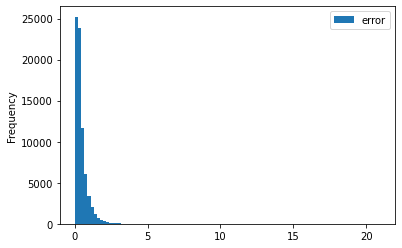

In [9]:
breath_mae = ev.calc_breath_mae()
breath_mae = breath_mae.sort_values("error", ascending=False)
breath_mae.plot.hist(bins=100)
plt.show()

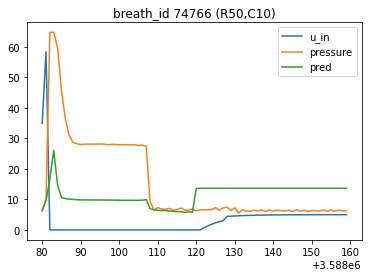

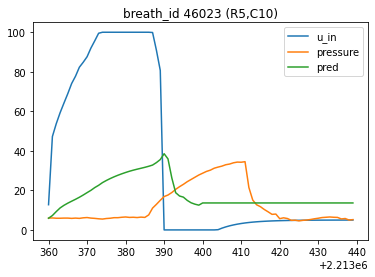

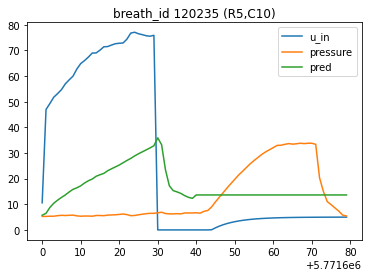

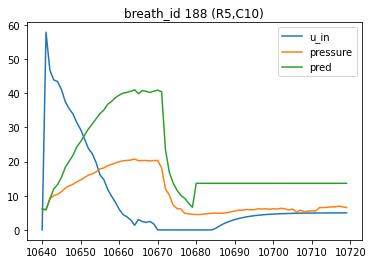

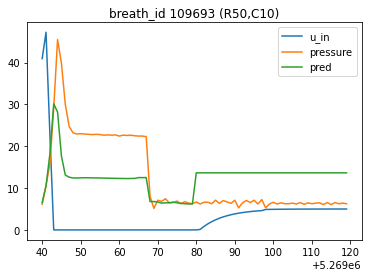

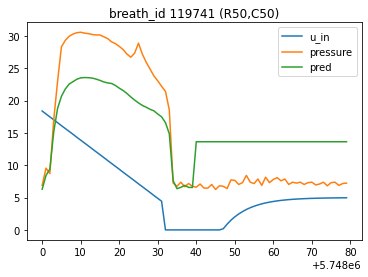

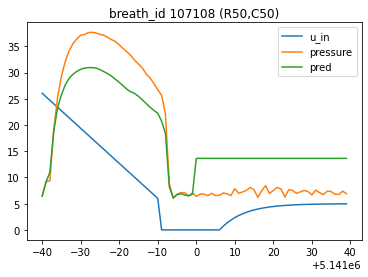

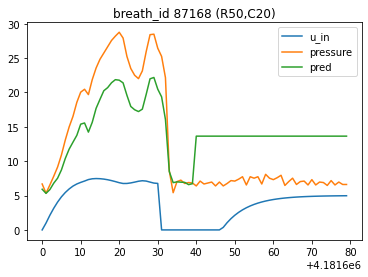

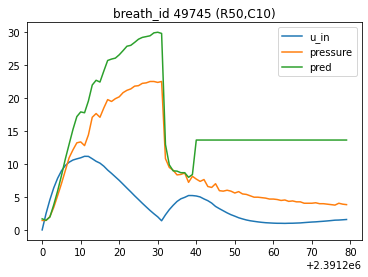

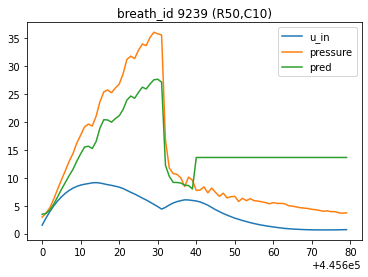

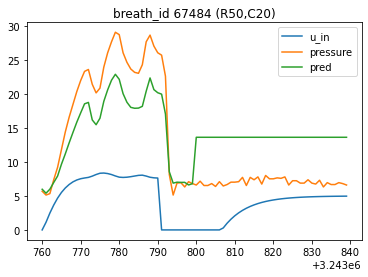

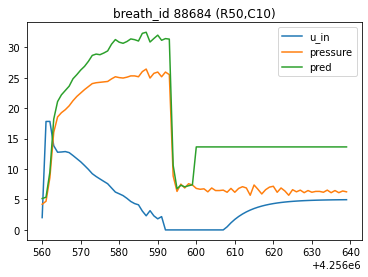

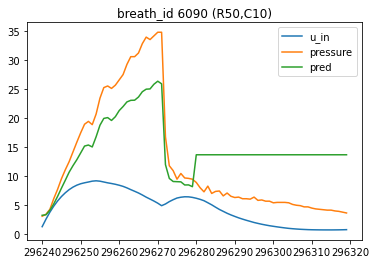

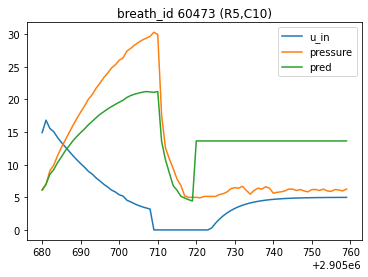

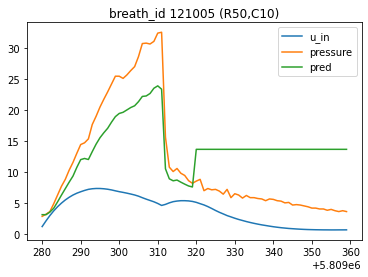

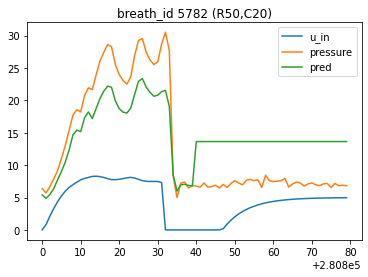

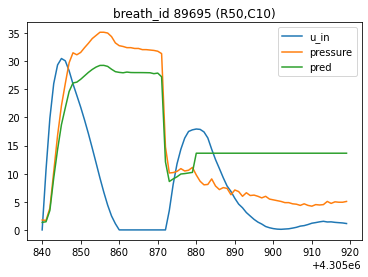

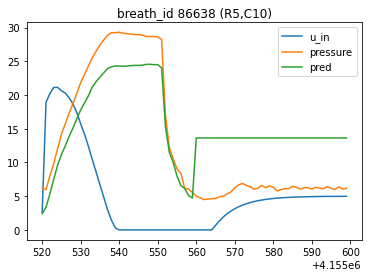

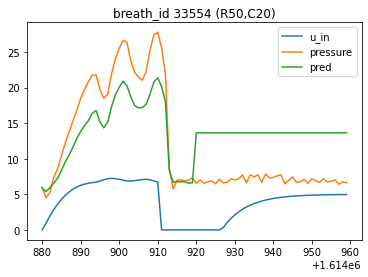

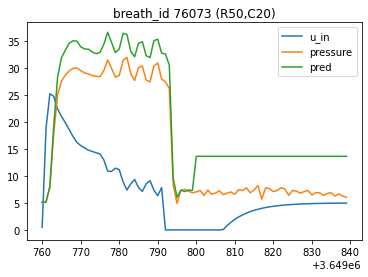

In [10]:
n_plot = 20
for i in range(n_plot):
    ev.plot_breath(breath_mae.index[i])

## 推論

In [11]:
def run_predict(model, df):
    x = make_x(df)
    pred = model.predict(x)
    return pred    

In [12]:
model = []
for fold in range(n_fold):
    with open(f"fold{fold}_model.pickle", 'rb') as p:
        mdl = pickle.load(p)
    model.append(mdl)

model = ut.EnsembleModel(model)

In [13]:
pred = run_predict(model, ts_df)
sub_df = ts_df[["id"]].copy()
sub_df["pressure"] = pred
sub_df.to_csv(f"submission_{os.path.basename(os.getcwd())}.csv", index=False)

100%|██████████| 50/50 [02:07<00:00,  2.55s/it]
